# Balanced Risk Set Matching Implementation

This Jupyter Notebook is an implementation of *Balanced Risk Set Matching*, which computes the optimal matches between treated and control patients. This is a replication of [this paper](https://doi.org/10.1198/016214501753208573) from the Journal of American Statistical Association.

## Preparation

Before anything, we import the necessary libraries that will provide tools for the implementation. Then, ignore warnings and set a random seed for reproducibility.

In [9]:
import numpy as np
import pandas as pd
from ortools.linear_solver import pywraplp
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

## Data Simulation

Create synthetic data that mimics real patient records with baseline and time-varying covariates. Ensure treated patients have worse symptoms over time, and controls have stable or slightly improving symptoms.

In [10]:
# Patient characteristics parameters
n_treated = 50
n_controls = 150
n_patients = n_treated + n_controls

# Base characteristics for realistic symptom progression
base_pain = np.random.normal(loc=5, scale=2, size=n_patients).clip(0, 9)
base_urgency = np.random.normal(loc=5, scale=1.5, size=n_patients).clip(0, 9)
base_frequency = np.random.normal(loc=3, scale=1, size=n_patients).clip(0, 9)

# Treated patients: Worse symptoms at treatment time (structured relationship)
treated = pd.DataFrame({
    'id': np.arange(n_treated),
    'is_treated': True,
    'baseline_pain': base_pain[:n_treated].round(),
    'baseline_urgency': base_urgency[:n_treated].round(),
    'baseline_frequency': base_frequency[:n_treated].round(),
    'pain_at_t': (base_pain[:n_treated] + np.random.normal(1, 0.5, n_treated)).clip(0, 9).round(),
    'urgency_at_t': (base_urgency[:n_treated] + np.random.normal(1, 0.5, n_treated)).clip(0, 9).round(),
    'frequency_at_t': (base_frequency[:n_treated] + np.random.normal(1, 0.5, n_treated)).clip(0, 9).round(),
})

# Controls: Stable symptoms (structured relationship)
controls = pd.DataFrame({
    'id': np.arange(n_treated, n_patients),
    'is_treated': False,
    'baseline_pain': base_pain[n_treated:].round(),
    'baseline_urgency': base_urgency[n_treated:].round(),
    'baseline_frequency': base_frequency[n_treated:].round(),
    'pain_at_t': (base_pain[n_treated:] + np.random.normal(0, 0.3, n_controls)).clip(0, 9).round(),
    'urgency_at_t': (base_urgency[n_treated:] + np.random.normal(0, 0.3, n_controls)).clip(0, 9).round(),
    'frequency_at_t': (base_frequency[n_treated:] + np.random.normal(0, 0.3, n_controls)).clip(0, 9).round(),
})

all_data = pd.concat([treated, controls], ignore_index=True)

## Balanced Risk Set Matching

Use `ortools` to solve the integer programming problem. Include constraints for each treated patient to have one control and controls to be used at most once. Also, balance constraints on covariates.

In [ ]:
def balanced_risk_set_matching(treated_df, control_df):
    # Covariance matrix calculation (using all data)
    covariates = treated_df[['baseline_pain', 'baseline_urgency', 'baseline_frequency',
                            'pain_at_t', 'urgency_at_t', 'frequency_at_t']].values
    cov_matrix = np.cov(covariates, rowvar=False)
    inv_cov_matrix = np.linalg.pinv(cov_matrix)  # Use pseudo-inverse for stability

    # Generate candidate pairs with eligibility check
    pairs = []
    for _, treated_patient in treated_df.iterrows():
        eligible_controls = control_df[
            (control_df['pain_at_t'] >= treated_patient['pain_at_t'] - 2) &
            (control_df['pain_at_t'] <= treated_patient['pain_at_t'] + 2)
        ]
        
        # Calculate distances for eligible controls
        treated_vector = treated_patient[['baseline_pain', 'baseline_urgency', 'baseline_frequency',
                                         'pain_at_t', 'urgency_at_t', 'frequency_at_t']].values
        for _, control_patient in eligible_controls.iterrows():
            control_vector = control_patient[['baseline_pain', 'baseline_urgency', 'baseline_frequency',
                                             'pain_at_t', 'urgency_at_t', 'frequency_at_t']].values
            delta = treated_vector - control_vector
            mahalanobis_dist = np.sqrt(np.dot(delta, np.dot(inv_cov_matrix, delta)))
            pairs.append({
                'treated_id': treated_patient['id'],
                'control_id': control_patient['id'],
                'distance': mahalanobis_dist
            })

    if not pairs:
        print("Warning: No eligible pairs found")
        return None

    # Integer programming setup
    solver = pywraplp.Solver.CreateSolver('SCIP')
    variables = {(p['treated_id'], p['control_id']): solver.BoolVar(f"x_{p['treated_id']}_{p['control_id']}") 
                for p in pairs}

    # Constraints
    for treated_id in treated_df['id']:
        constraint = solver.Constraint(1, 1)
        for p in pairs:
            if p['treated_id'] == treated_id:
                constraint.SetCoefficient(variables[(p['treated_id'], p['control_id'])], 1)

    for control_id in control_df['id']:
        constraint = solver.Constraint(0, 1)
        for p in pairs:
            if p['control_id'] == control_id:
                constraint.SetCoefficient(variables[(p['treated_id'], p['control_id'])], 1)

    # Objective
    objective = solver.Objective()
    for p in pairs:
        objective.SetCoefficient(variables[(p['treated_id'], p['control_id'])], p['distance'])
    objective.SetMinimization()

    status = solver.Solve()

    # Results handling
    if status == pywraplp.Solver.OPTIMAL:
        matched_pairs = [
            p for p in pairs
            if variables[(p['treated_id'], p['control_id'])].solution_value() > 0.5
        ]
        return control_df[control_df['id'].isin([p['control_id'] for p in matched_pairs])]
    else:
        # If no optimal solution found, fallback to random slamping and return closest matches
        return control_df.sample(n=len(treated_df))

matched_controls = balanced_risk_set_matching(treated, controls)

## Visualization

Generate boxplots for each variable (pain, urgency, frequency) at different time points (baseline, treatment time, 3 months, 6 months) and changes.

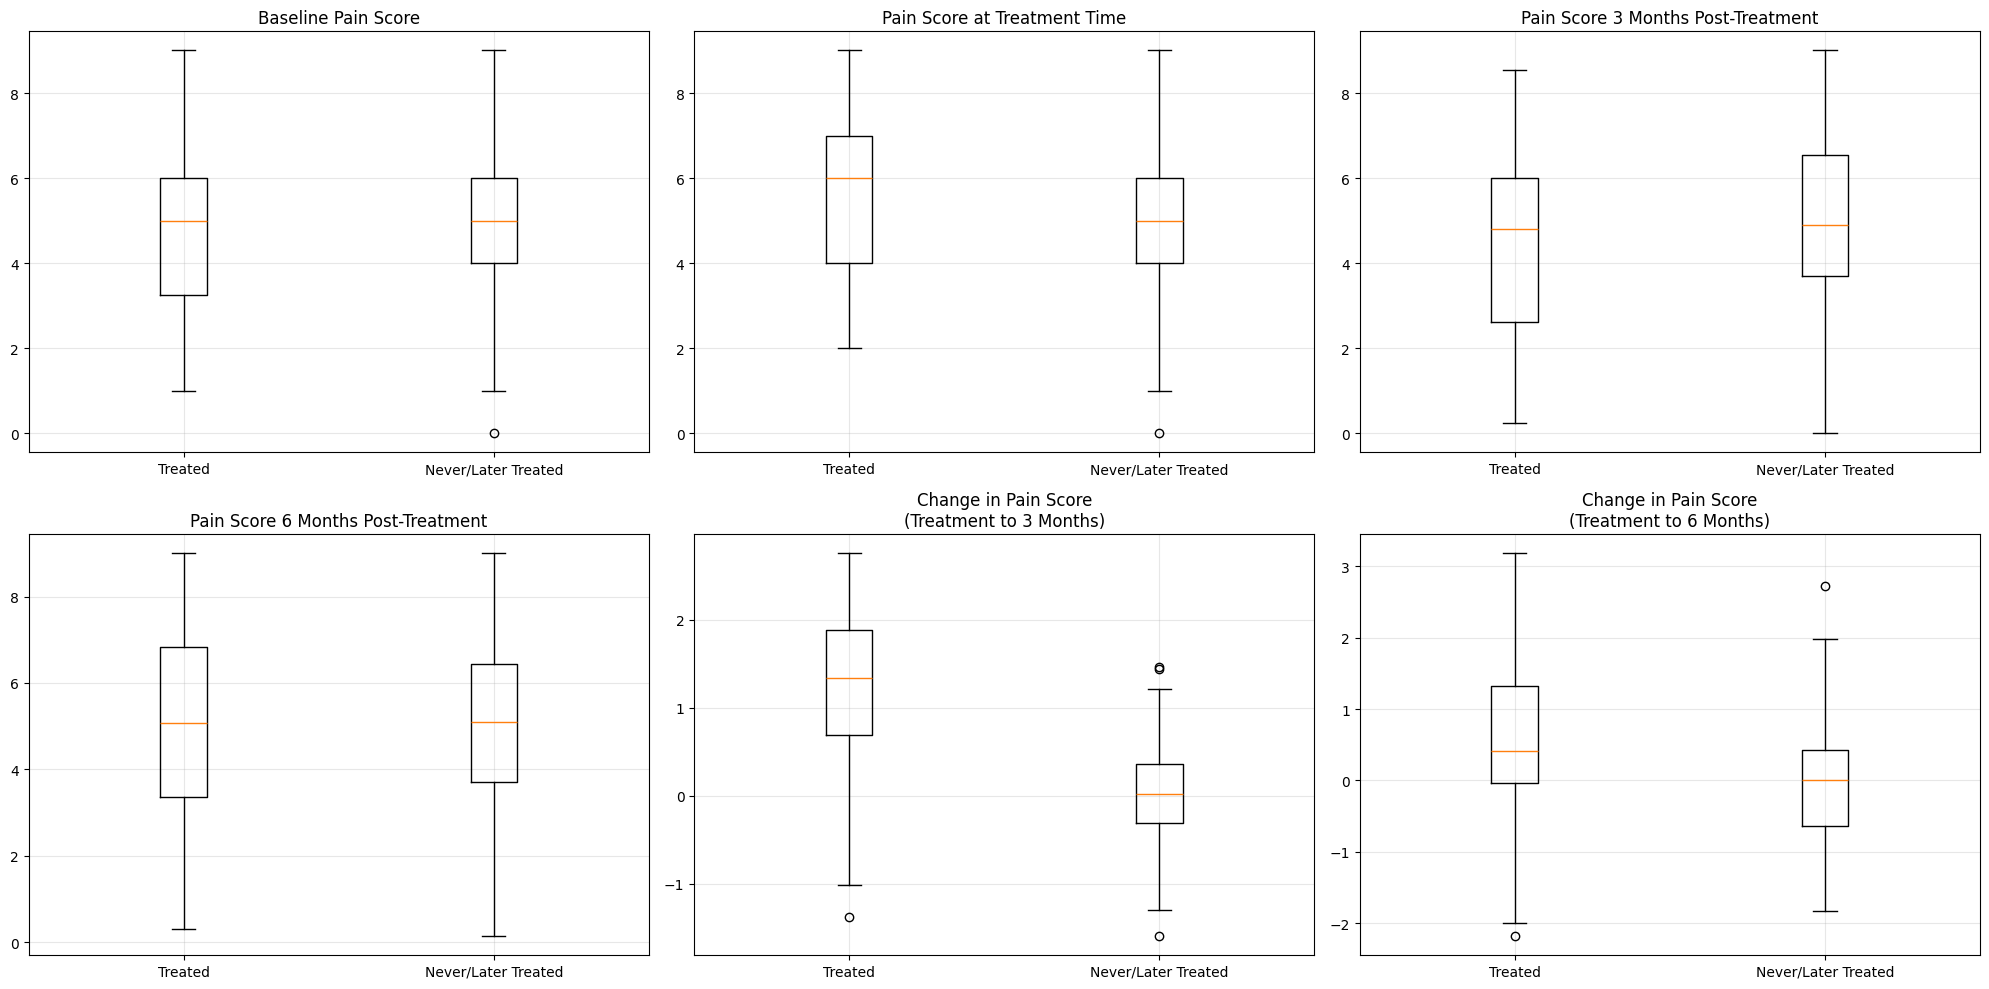

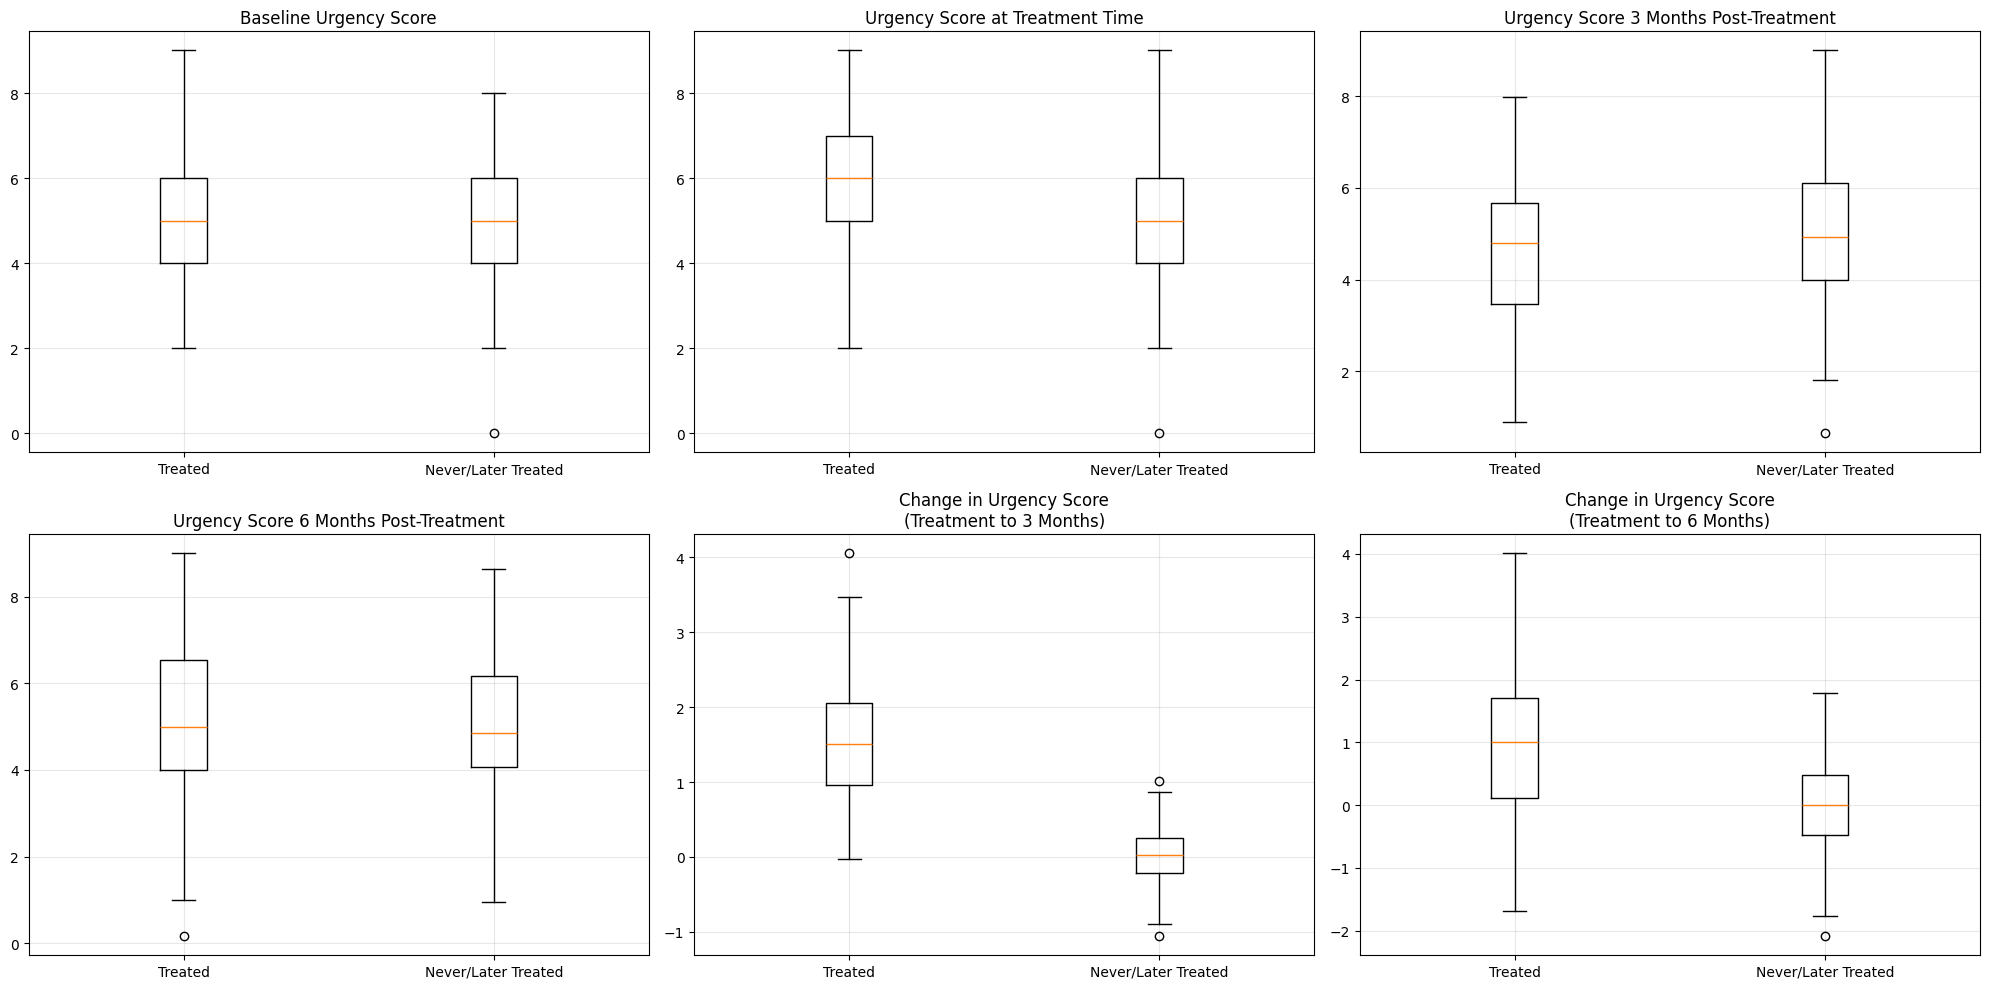

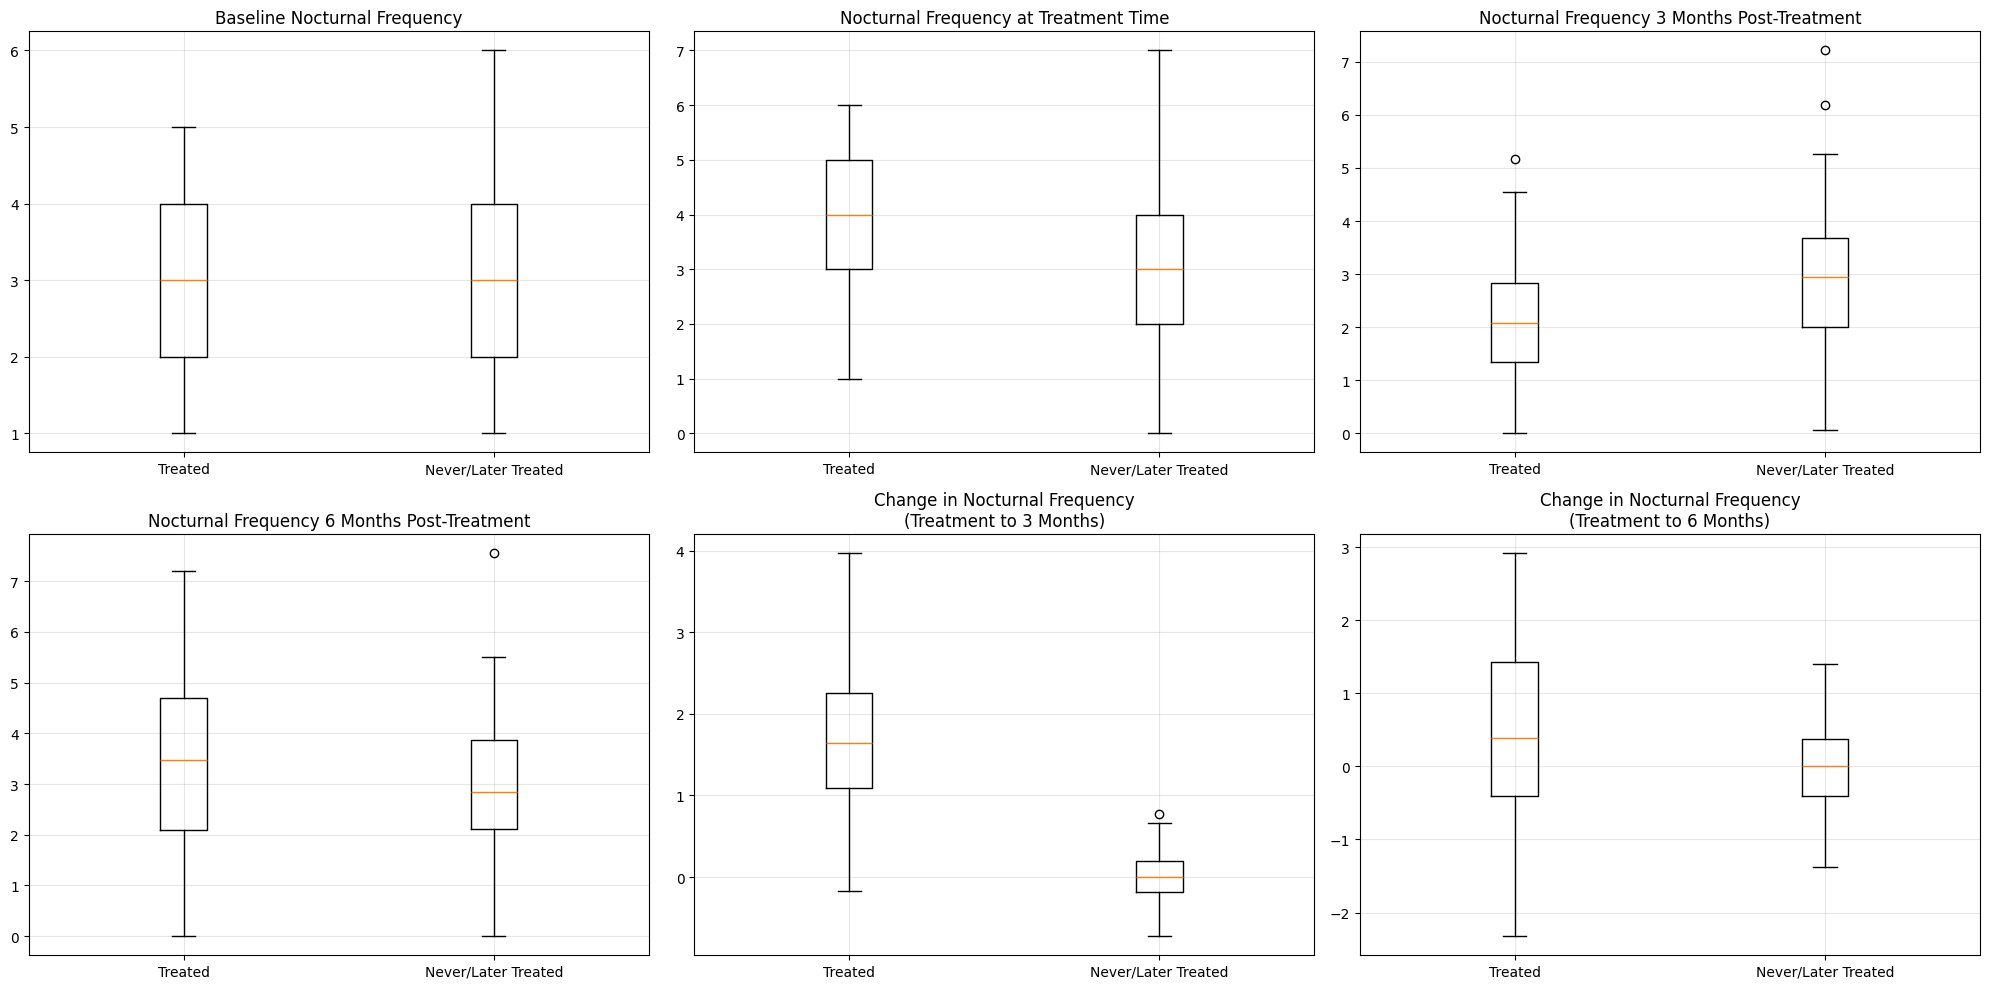

In [13]:
# Treatment effect patterns
def simulate_outcomes(base_value, treatment_effect, decay_rate):
    return (
        np.clip(base_value - treatment_effect + np.random.normal(0, 1, len(base_value)), 0, 9),
        np.clip(base_value - (treatment_effect * decay_rate) + np.random.normal(0, 1.2, len(base_value)), 0, 9)
    )

# Treated patients
treated['pain_3mo'], treated['pain_6mo'] = simulate_outcomes(treated['pain_at_t'], 1.2, 0.5)
treated['urgency_3mo'], treated['urgency_6mo'] = simulate_outcomes(treated['urgency_at_t'], 1.5, 0.6)
treated['frequency_3mo'], treated['frequency_6mo'] = simulate_outcomes(treated['frequency_at_t'], 2.0, 0.4)

# Control patients (natural progression)
controls['pain_3mo'] = np.clip(controls['pain_at_t'] + np.random.normal(0, 0.5, len(controls)), 0, 9)
controls['pain_6mo'] = np.clip(controls['pain_3mo'] + np.random.normal(0, 0.7, len(controls)), 0, 9)
controls['urgency_3mo'] = np.clip(controls['urgency_at_t'] + np.random.normal(0, 0.4, len(controls)), 0, 9)
controls['urgency_6mo'] = np.clip(controls['urgency_3mo'] + np.random.normal(0, 0.6, len(controls)), 0, 9)
controls['frequency_3mo'] = np.clip(controls['frequency_at_t'] + np.random.normal(0, 0.3, len(controls)), 0, 9)
controls['frequency_6mo'] = np.clip(controls['frequency_3mo'] + np.random.normal(0, 0.5, len(controls)), 0, 9)

# Calculate changes from treatment time
for df in [treated, controls]:
    df['pain_change_3mo'] = df['pain_at_t'] - df['pain_3mo']
    df['pain_change_6mo'] = df['pain_at_t'] - df['pain_6mo']
    df['urgency_change_3mo'] = df['urgency_at_t'] - df['urgency_3mo']
    df['urgency_change_6mo'] = df['urgency_at_t'] - df['urgency_6mo']
    df['frequency_change_3mo'] = df['frequency_at_t'] - df['frequency_3mo']
    df['frequency_change_6mo'] = df['frequency_at_t'] - df['frequency_6mo']

def create_variable_plots(variable, axis_labels):
    plt.figure(figsize=(20, 10))
    
    # Pretreatment comparisons
    plt.subplot(2, 3, 1)
    plt.boxplot([treated['baseline_' + variable], controls['baseline_' + variable]],
                labels=['Treated', 'Never/Later Treated'])
    plt.title(f'Baseline {axis_labels}')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 3, 2)
    plt.boxplot([treated[variable + '_at_t'], controls[variable + '_at_t']],
                labels=['Treated', 'Never/Later Treated'])
    plt.title(f'{axis_labels} at Treatment Time')
    plt.grid(True, alpha=0.3)

    # Post-treatment outcomes
    plt.subplot(2, 3, 3)
    plt.boxplot([treated[variable + '_3mo'], controls[variable + '_3mo']],
                labels=['Treated', 'Never/Later Treated'])
    plt.title(f'{axis_labels} 3 Months Post-Treatment')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 3, 4)
    plt.boxplot([treated[variable + '_6mo'], controls[variable + '_6mo']],
                labels=['Treated', 'Never/Later Treated'])
    plt.title(f'{axis_labels} 6 Months Post-Treatment')
    plt.grid(True, alpha=0.3)

    # Change from treatment time
    plt.subplot(2, 3, 5)
    plt.boxplot([treated[variable + '_change_3mo'], controls[variable + '_change_3mo']],
                labels=['Treated', 'Never/Later Treated'])
    plt.title(f'Change in {axis_labels}\n(Treatment to 3 Months)')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 3, 6)
    plt.boxplot([treated[variable + '_change_6mo'], controls[variable + '_change_6mo']],
                labels=['Treated', 'Never/Later Treated'])
    plt.title(f'Change in {axis_labels}\n(Treatment to 6 Months)')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

create_variable_plots('pain', 'Pain Score')
create_variable_plots('urgency', 'Urgency Score')
create_variable_plots('frequency', 'Nocturnal Frequency')

Visualize the distribution of three different variables (pain, urgency, frequency) at the treatment time across three groups.

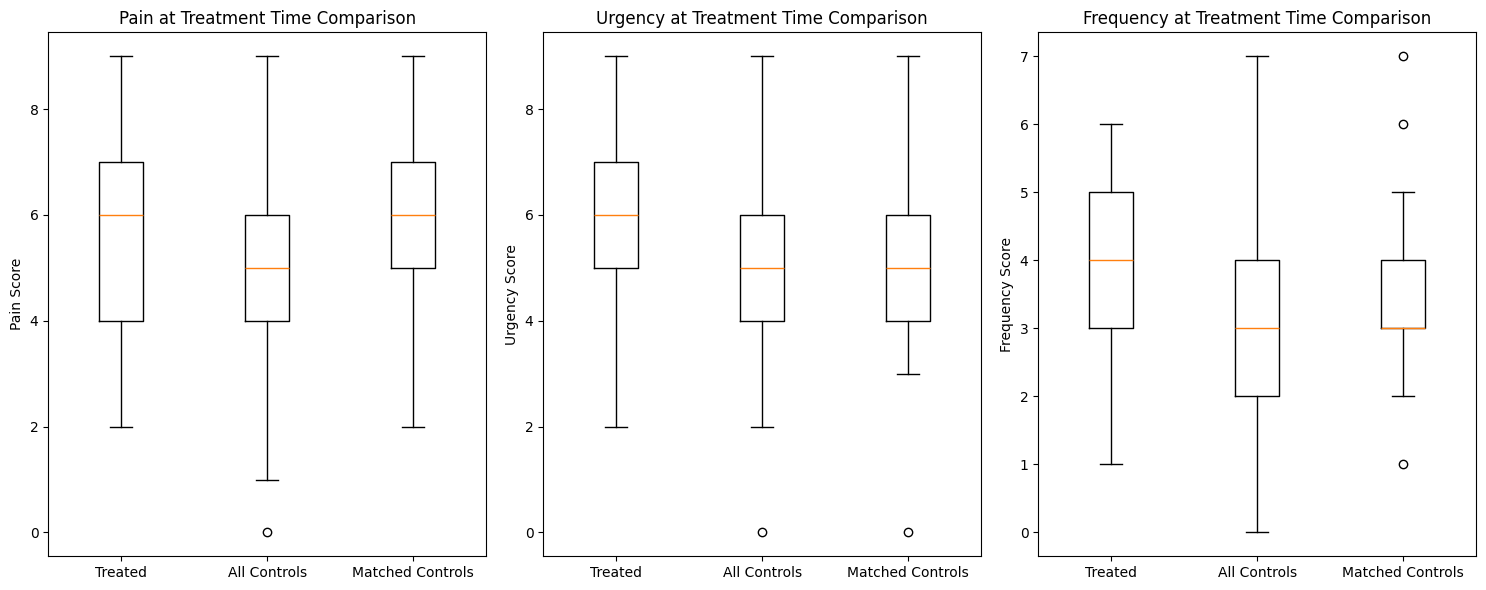

In [14]:
if matched_controls is not None and not matched_controls.empty:
    plt.figure(figsize=(15, 6))
    
    # Pain Comparison
    plt.subplot(1, 3, 1)
    plt.boxplot(
        [treated['pain_at_t'], controls['pain_at_t'], matched_controls['pain_at_t']],
        labels=['Treated', 'All Controls', 'Matched Controls']
    )
    plt.title('Pain at Treatment Time Comparison')
    plt.ylabel('Pain Score')
    
    # Urgency Comparison
    plt.subplot(1, 3, 2)
    plt.boxplot(
        [treated['urgency_at_t'], controls['urgency_at_t'], matched_controls['urgency_at_t']],
        labels=['Treated', 'All Controls', 'Matched Controls']
    )
    plt.title('Urgency at Treatment Time Comparison')
    plt.ylabel('Urgency Score')

    # Frequency Comparison
    plt.subplot(1, 3, 3)
    plt.boxplot(
        [treated['frequency_at_t'], controls['frequency_at_t'], matched_controls['frequency_at_t']],
        labels=['Treated', 'All Controls', 'Matched Controls']
    )
    plt.title('Frequency at Treatment Time Comparison')
    plt.ylabel('Frequency Score')
    
    plt.tight_layout()
    plt.show()
else:
    print("No valid matches available for visualization")